### Gaining Insights From Evictions Data

#### Libraries Used
1) Pandas - For Data Manipulation

2) Seaborn And Matplotlib - For Data Visualisation

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

#### Initialising Connection to the DB

In [2]:
engine = create_engine("mysql+pymysql://" + "root" + ":" + "hero@123" + "@" + "localhost" + "/" + "sf_prod")  

In [3]:
df = pd.read_sql('SELECT *FROM fact_evictions',engine)
df.head()

,eviction_key,location_key,district_key,neighborhood_key,reason_group_key,file_date_key,constraints_date_key,street_address,latitude,longitude
0,AL2K001,10,6,3,25,1879,-1,1600 Block Of Howard Street,-122.417274,37.771072
1,E2K2588,3,5,25,14,1835,-1,1200 Block Of 04th Avenue,-122.46099,37.76474
2,E980002,26,1,1,1,3240,-1,1500 Block Of California Street,-122.41986,37.790684
3,E980003,22,3,8,28,3240,-1,1600 Block Of Alabama Street,-122.41053,37.74595
4,E980004,7,2,13,2,3240,-1,400 Block Of Leland Avenue,-122.41249,37.713936


### Lets Visualise

#### Rise And Fall Trend of Evictions Over The Years

<AxesSubplot:xlabel='year', ylabel='eviction_count'>

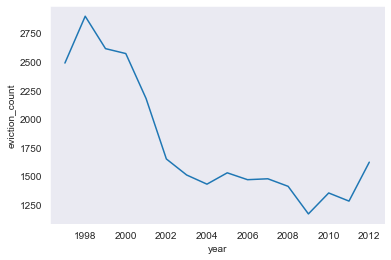

In [4]:
eviction_trend = """
SELECT dd.year,COUNT(*) AS eviction_count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_date dd
ON fe.file_date_key = dd.date_key
GROUP BY dd.year
ORDER BY dd.year; 
"""

trend_df = pd.read_sql(eviction_trend,engine)
sns.lineplot(data = trend_df, x = "year", y = "eviction_count")

<AxesSubplot:xlabel='year', ylabel='eviction_count'>

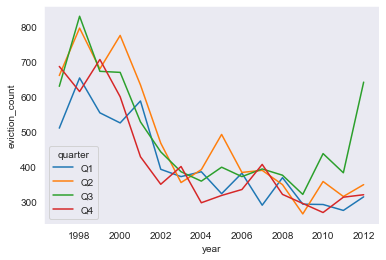

In [5]:
eviction_trend_bm = """
SELECT dd.year,dd.quartal AS quarter,COUNT(*) AS eviction_count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_date dd
ON fe.file_date_key = dd.date_key
GROUP BY dd.year,dd.quartal
ORDER BY dd.year; 
"""

trend_bm_df = pd.read_sql(eviction_trend_bm,engine)
sns.lineplot(data = trend_bm_df, x = "year", y = "eviction_count",hue = "quarter")

#### Over The Past Two Years

<AxesSubplot:xlabel='month_year', ylabel='count'>

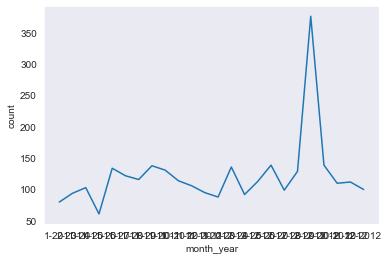

In [25]:
eviction_past2 = """
SELECT dd.month,dd.year,COUNT(*) AS count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_date dd
ON fe.file_date_key = dd.date_key
WHERE dd.date >= (SELECT DATE_SUB(MAX(date),INTERVAL 2 YEAR) FROM sf_prod.dim_date)
GROUP BY dd.month,dd.year
ORDER BY dd.year,dd.month;

"""


eviction_past2 = pd.read_sql(eviction_past2,engine)
eviction_past2.head()
eviction_past2['month_year'] = eviction_past2['month'].map(str) + "-" + eviction_past2['year'].map(str)
eviction_past2 = eviction_past2.drop(['month','year'],axis = 1)
sns.lineplot(data = eviction_past2, x = "month_year", y = "count")

#### Evicitions By District And Neighborhood

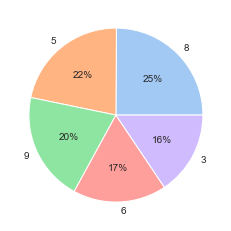

In [6]:
eviction_dist = """
SELECT dd.district,COUNT(*) AS evictions_count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_district dd
ON fe.district_key = dd.district_key
GROUP BY dd.district
ORDER BY COUNT(*) DESC
LIMIT 5;
"""

eviction_dist_df = pd.read_sql(eviction_dist,engine)
eviction_dist_df.head()

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(eviction_dist_df['evictions_count'], labels = eviction_dist_df['district'], colors = colors, autopct='%.0f%%')
plt.show()

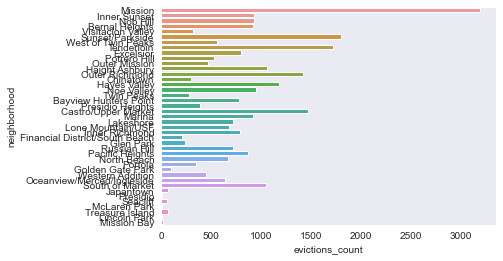

In [7]:
eviction_neighborhood = """
SELECT dd.neighborhood,COUNT(*) AS evictions_count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_neighborhood dd
ON fe.neighborhood_key = dd.neighborhood_key
GROUP BY dd.neighborhood
"""

eviction_neighborhood_df = pd.read_sql(eviction_neighborhood,engine)
eviction_neighborhood_df.head()

ax = sns.barplot(x = "evictions_count", y = "neighborhood", data = eviction_neighborhood_df)


#### Analysing Evictions Type

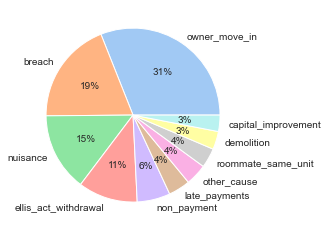

In [8]:
evictions_type = """
SELECT dr.reason_desc,COUNT(*) AS count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_mod_reason dr
ON fe.reason_group_key = dr.reason_key
GROUP BY dr.reason_desc
ORDER BY COUNT(*) DESC
LIMIT 10;
"""

eviction_type_df = pd.read_sql(evictions_type,engine)
colors = sns.color_palette('pastel')

#create pie chart
plt.pie(eviction_type_df['count'], labels = eviction_type_df['reason_desc'], colors = colors, autopct='%.0f%%')
plt.show()

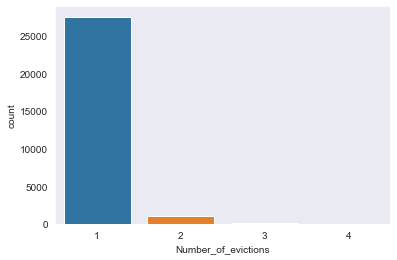

In [11]:
evictions_type_count = """
SELECT dr.reason_desc,COUNT(*) AS count
FROM sf_prod.fact_evictions fe
INNER JOIN sf_prod.dim_mod_reason dr
ON fe.reason_group_key = dr.reason_key
GROUP BY dr.reason_desc
ORDER BY COUNT(*) DESC;
"""

eviction_type_count_df = pd.read_sql(evictions_type_count,engine)
eviction_type_count_df['Number_of_evictions'] = eviction_type_count_df['reason_desc'].str.count("[|]")+1
evictions_by_count = eviction_type_count_df
evictions_by_count.head()
eviction_grpby_count = evictions_by_count.groupby(by=["Number_of_evictions"], dropna=False).sum()
eviction_grpby_count = eviction_grpby_count.reset_index(level=['Number_of_evictions'])
eviction_grpby_count.head()
ax = sns.barplot(x = "Number_of_evictions", y = "count", data = eviction_grpby_count)